# Deep-Learning-Based Vuggy Facies Identification from Borehole Images
Source of the idea: https://www.researchgate.net/publication/344755725_Deep-Learning-Based_Vuggy_Facies_Identification_from_Borehole_Images  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import random

from datetime import datetime

import torch
import torchvision as tv
import torchmetrics as tm

from torch import nn
from torch.nn import functional as F
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.utils.data import Dataset

from skimage import io
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
from time import perf_counter, sleep

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

import optuna

from torchmetrics import ConfusionMatrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

# Set seeds for every lib
set_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Random seed set as 42


device(type='cuda', index=0)

In [138]:
# Open the dataset
# Sizes with formatting as x,y
image_sizes = {
    10:  (1152,  118), 
    # 20:  (1152,  236), 
    40:  (1152,  472), 
    # 60:  (1152,  708), 
    70: (1152, 826),
    # 80:  (1152,  944), 
    100: (1152, 1180) 
}

# Input options
# input_infos = ['AW', 'TT', 'Tabular']
# input_infos = ['AW', 'Tabular']
input_infos = ['AW', 'TT'] # -> Best option so far
# input_infos = ['AW']
# input_infos = ['TT', 'Tabular'] X
# input_infos = ['TT'] X 
# input_infos = ['Tabular']

wells_basepaths = {
    '7-LL-11':  './dataset/7-LL-11',
    '7-LL-69':  './dataset/7-LL-69',
    '8-LL-112': './dataset/8-LL-112',
    '8-LL-92':  './dataset/8-LL-92',
    '3-BRSA-1201': './dataset/3-BRSA-1201',
    '9-BRSA-1254': './dataset/9-BRSA-1254',
    # '9-LL-2': './dataset/Blind 9-LL-2'
}

CLASS_NAMES = [
        'Non-Vug',                          # 0
        'Incipient Matrix Dissolution',     # 1
        'Incipient Fracture Dissolution',   # 2
        'Intense Matrix Dissolution',       # 3
        'Intense Fracture Dissolution',     # 4
        'Well Developed Karst'              # 5
    ]
TARGET = 'User Class'
TABULAR_COLUMNS = []

batch_size = 24
selected_cut_height = 100
reduction_factor = 3

In [139]:
columns = ['Depth', 'Filename-Static', 'Filename-Travel-Time', TARGET]
image_size = (int(image_sizes[selected_cut_height][1]/reduction_factor), int(image_sizes[selected_cut_height][0]/reduction_factor))

In [ ]:
for ch in [10, 40, 70, 100]:

    classes = []
    for well_name, well_path in wells_basepaths.items():
        basepath = os.path.join(well_path, 'Static', f'Corte {ch}')

        df_data = pd.read_excel(f'{well_path}/{well_name}-CNN_CLASS-{ch}cm(FINAL).xlsx')
        df_data = df_data[columns]
        print(well_name, df_data[TARGET].shape)

        classes.extend(df_data[TARGET].to_list())

    # If ch == 100, adds an additional data to improve training
    if ch == 100:
        new_100 = pd.read_excel('./dataset/Classes para treino 100cm/new-patches-ch-100.xlsx')
        new_100 = new_100[['Filename-Static', 'Filename-Travel-Time', 'User Class']]
        classes.extend(new_100[TARGET].to_list())

    unique_n, unique_c = np.unique(classes, return_counts=True)
    print(f'Cut height {str(ch): >3}', '->', ', '.join([str(x) for x in unique_n]), '->', ', '.join([str(x) for x in unique_c]), '-> total:', len(classes))

In [142]:
import warnings
warnings.filterwarnings("ignore") # BAD PRACTICE! But necessary sometimes...

def get_checkpoint_prefix(input_infos):
    prefixes = []
    if 'AW' in input_infos:
        prefixes.append('AW')
    if 'TT' in input_infos:
        prefixes.append('TT')
    if 'Tabular' in input_infos:
        prefixes.append('-'.join(TABULAR_COLUMNS))
    
    return '-'.join(prefixes)
get_checkpoint_prefix(input_infos)

'AW-TT'

In [143]:
pattern = r"(.+)-(PT\d{1,2})-crop-(\d{1,3})\.png"

class ImagelogDataset(Dataset):
   def __init__(
               self, 
               df, 
               target, 
               class_names, 
               tabular_columns,
               phase,
               inputs=['AW', 'TT', 'Tabular'], 
               dtype_min_max=(0, 255), 
               min_max = (-1, 1), 
               target_size = (108, 352), 
               train_augmentation=False):
               
      self.df = df
      self.class_names = class_names
      self.phase = phase
      self.min_max = min_max
      self.dtype_min_max = dtype_min_max
      self.train_augmentation = train_augmentation
      self.tabular_columns = tabular_columns
      self.target = target
      self.inputs = inputs

      if 'AW' in inputs:
         self.images_amp = [np.array(Image.open(fn).resize(size=target_size[::-1], resample=Image.Resampling.BICUBIC)) for fn in self.df['Filename-Static']] #  .transpose((2,0,1))
         for img_idx in range(len(self.images_amp)):
            if self.images_amp[img_idx].shape[-1] == 4:
               self.images_amp[img_idx] = self.images_amp[img_idx][:, :, :3]

      if 'TT' in inputs:
         self.images_tt  = [np.array(Image.open(fn).resize(size=target_size[::-1], resample=Image.Resampling.BICUBIC)) for fn in self.df['Filename-Travel-Time']] #  .transpose((2,0,1))
         for img_idx in range(len(self.images_tt)):
            if self.images_tt[img_idx].shape[-1] == 4:
               self.images_tt[img_idx] = self.images_tt[img_idx][:, :, :3]

      if 'Tabular' in inputs:
         self.tabular = self.df[tabular_columns]#.to_list()

      self.classes =  self.df[target]#.to_list()

      self.data_len = len(self.classes)
        
   def __len__(self):
      return self.data_len

   def transform(self, image, p=.5, rect_sizes_min_max=[(.05, .05), (.40, .40)]):
      image = Image.fromarray(image)

      # ColorJitter
      # if random.random() < p:
      #    brightness  = random.choice(np.linspace(0.8, 1.2, 5))
      #    contrast    = random.choice(np.linspace(0.8, 1.2, 5))
      #    saturation  = random.choice(np.linspace(0.8, 1.2, 5))
      #    sharpness   = random.choice(np.linspace(0.8, 1.2, 5))

      #    image = tv.transforms.functional.adjust_brightness(image, brightness)
      #    image = tv.transforms.functional.adjust_contrast(image, contrast)
      #    image = tv.transforms.functional.adjust_saturation(image, saturation)
      #    image = tv.transforms.functional.adjust_sharpness(image, sharpness)

      # RandomHorizontalFlip
      if random.random() < p:
         image = tv.transforms.functional.hflip(image)

      # RandomVerticalFlip
      if random.random() < p:
         image = tv.transforms.functional.vflip(image)

      # Random black rectangles on the image
      # image = np.array(image)
      # if random.random() < p:
      #    top    = np.random.randint(0, int((1-rect_sizes_min_max[1][0])*image.shape[0]))
      #    left   = np.random.randint(0, int((1-rect_sizes_min_max[1][1])*image.shape[1]))
      #    height = np.random.randint(int(rect_sizes_min_max[0][0]*image.shape[0]), int(rect_sizes_min_max[1][0]*image.shape[0]))
      #    width  = np.random.randint(int(rect_sizes_min_max[0][1]*image.shape[1]), int(rect_sizes_min_max[1][1]*image.shape[1]))
      #    image[top:top+height, left:left+width] = 0

      # Random changes on azimuth
      if random.random() < p:
        shift_step = 10
        shift = random.choice(np.arange(shift_step, image.shape[-1], shift_step))
        
        image = torch.roll(image, shift, dims=-1)

      return image

   def normalize(self, img):
      # 0 to 1
      image = (img - self.dtype_min_max[0])/(self.dtype_min_max[1]-self.dtype_min_max[0])
      # -1 to 1
      image = image * (self.min_max[1] - self.min_max[0]) + self.min_max[0]

      return image

   def __getitem__(self, index):
      item = {
         'index': index, 
         'class': np.array(self.classes.iloc[index]), 
         'filename': self.df.loc[index, 'Filename-Static']}

      if 'AW' in self.inputs:
         image_amp = self.images_amp[index]
         if self.train_augmentation:
            image_amp = self.transform(image_amp)
         image_amp = self.normalize(image_amp)
         item['AW'] = image_amp.transpose((2,0,1))

      if 'TT' in self.inputs:
         image_tt = self.images_tt[index]
         if self.train_augmentation:
            image_tt  = self.transform(image_tt)
         image_tt  = self.normalize(image_tt)
         item['TT'] = image_tt.transpose((2,0,1))

      if 'Tabular' in self.inputs:
         item['Tabular'] = self.tabular.iloc[index]

      return item

def get_vision_model(
               model=tv.models.mobilenet_v3_small,
               weights='DEFAULT',
               last_layer=3,
               n_filters=32,
               n_layers=1,
            ):

    # create model
    model = model(weights=weights)

    if 'AW' in input_infos and 'TT' in input_infos:
        in_channels = 6
    else:
        in_channels = 3

    # freeze the layers
    if weights:
        for param in model.parameters():
            param.requires_grad = False

    # Modify the first layer to accept 3 or 6 channels
    if hasattr(model, 'features'):
        first_layer = model.features[0][0]
        model.features[0][0] = nn.Conv2d(in_channels, first_layer.out_channels,  kernel_size=first_layer.kernel_size, stride=first_layer.stride, padding=first_layer.padding, bias=False)
    if hasattr(model, 'stem'):
        first_layer = model.stem[0]
        model.stem[0] = nn.Conv2d(in_channels, first_layer.out_channels,  kernel_size=first_layer.kernel_size, stride=first_layer.stride, padding=first_layer.padding, bias=False)
    elif hasattr(model, 'conv1'):
        if type(model.conv1) == nn.modules.container.Sequential:
            first_layer = model.conv1[0]
            model.conv1[0] = nn.Conv2d(in_channels, first_layer.out_channels,  kernel_size=first_layer.kernel_size, stride=first_layer.stride, padding=first_layer.padding, bias=False)
        elif type(model.conv1) == type(tv.models.googlenet().conv1):
            first_layer = model.conv1.conv
            model.conv1.conv = nn.Conv2d(in_channels, first_layer.out_channels,  kernel_size=first_layer.kernel_size, stride=first_layer.stride, padding=first_layer.padding, bias=False)
        else:
            first_layer = model.conv1
            model.conv1 = nn.Conv2d(in_channels, first_layer.out_channels,  kernel_size=first_layer.kernel_size, stride=first_layer.stride, padding=first_layer.padding, bias=False)
    elif hasattr(model, 'layers'):
        if type(model.layers) == nn.modules.container.Sequential:
            first_layer = model.layers[0]
            model.layers[0] = nn.Conv2d(in_channels, first_layer.out_channels,  kernel_size=first_layer.kernel_size, stride=first_layer.stride, padding=first_layer.padding, bias=False)
        else:
            first_layer = model.layers
            model.layers = nn.Conv2d(in_channels, first_layer.out_channels,  kernel_size=first_layer.kernel_size, stride=first_layer.stride, padding=first_layer.padding, bias=False)
    elif hasattr(model, 'heads'):
        number_features = model.heads.head.out_features
        features = list(model.heads.children())
        model.conv_proj = nn.Conv2d(in_channels, 768, kernel_size=(16, 16), stride=(16, 16))
        # model.conv_proj.in_channels = in_channels

    # Modify the last layer
    if hasattr(model, 'classifier'):
        number_features = model.classifier[last_layer].in_features
        features = list(model.classifier.children())[:-1] # Remove last layer
    elif hasattr(model, 'fc'):
        number_features = model.fc.in_features
        features = []

    if n_layers == 0:
        # features.append(torch.nn.Linear(number_features, len(CLASS_NAMES)))
        features.append(torch.nn.Linear(number_features, n_filters))
    else:
        features.extend([
                torch.nn.Linear(number_features, n_filters),
                torch.nn.ReLU(),
            ])

        for _ in range(n_layers-1):
            features.extend([
                torch.nn.Linear(n_filters, n_filters),
                torch.nn.ReLU(),
            ])

        features.append(torch.nn.Linear(n_filters, n_filters))

    if hasattr(model, 'classifier'):
        model.classifier = torch.nn.Sequential(*features)
    elif hasattr(model, 'fc'):
        model.fc = torch.nn.Sequential(*features)
    elif hasattr(model, 'heads'):
        model.heads = torch.nn.Sequential(*features)

    # model = model.to(device)

    return model

class VuggyClassifier(nn.Module):
   def __init__(self, 
            inputs,
            model=tv.models.mobilenet_v3_small,
            weights=tv.models.MobileNet_V3_Small_Weights.DEFAULT,
            last_layer=3,
            n_filters=32,
            n_layers=1,
            tabular_filters=8,
            dropout_ratio=.3):

      super(VuggyClassifier, self).__init__()

      self.inputs = inputs
      self.image = get_vision_model(model=model, weights=weights, last_layer=last_layer, n_filters=n_filters, n_layers=n_layers)
      
      self.tabular = nn.Sequential(
            nn.Linear(len(TABULAR_COLUMNS), tabular_filters),
            nn.ReLU(),
      )

      input_filters = 0
      if 'AW' in self.inputs or 'TT' in self.inputs:
         input_filters += n_filters
      if 'Tabular' in self.inputs:
         input_filters += tabular_filters
      
      layers = [nn.Linear(input_filters, n_filters), nn.LeakyReLU(), nn.Dropout(p=dropout_ratio), nn.BatchNorm1d(num_features=n_filters)]
      for _ in range(n_layers):
         layers.extend([
               nn.Linear(n_filters, n_filters),
               nn.LeakyReLU(),
            #    nn.Dropout(p=dropout_ratio),
            #    nn.BatchNorm1d(num_features=n_filters)
         ])
      layers.append(nn.Linear(n_filters, len(CLASS_NAMES))) #len(class_names)

      self.classifier = nn.Sequential(
         *layers
         # nn.Softmax() # the CrossEntropyLoss already has the softmax function built in ;D
      )

   def forward(self, x): # AW, TT, Tabular
      inputs = []

      if 'AW' in self.inputs and 'TT' in self.inputs:
         inputs.append(self.image(torch.cat((x['AW'], x['TT']), 1)))
      elif 'AW' in self.inputs:
         inputs.append(self.image(x['AW']))
      elif 'TT' in self.inputs:
         inputs.append(self.image(x['TT']))
      
      if 'Tabular' in self.inputs:
         inputs.append(self.tabular(x['Tabular']))

      if type(inputs[0]) == tv.models.GoogLeNetOutputs:
          inputs[0] = inputs[0].logits
      
      x = torch.cat(inputs, dim=1)

      x = self.classifier(x)
      # x = F.softmax(x, dim=0) # The CrossEntropyLoss has already a softmax layer
      # x = F.sigmoid(x) # only with BCELoss to have the probabilities. The BCEWithLogitsLoss already has a sigmoid layer.

      return x

In [144]:
def generate_profile(model, dataloader_all, type='classes'):
    # Generate profile
    y_pred = []
    index_pred = []
    fn_pred = []
    # y_true = []

    with torch.no_grad():
        for data in tqdm(dataloader_all):
            inputs_dict = {}
            if 'AW' in data.keys():
                inputs_dict['AW'] = data['AW'].float().to(device)
            if 'TT' in data.keys():
                inputs_dict['TT'] = data['TT'].float().to(device)
            if 'Tabular' in data.keys():
                inputs_dict['Tabular'] = data['Tabular'].float().to(device)

            outputs = torch.sigmoid(model(inputs_dict))
            
            if type=='max':
                _, preds = torch.max(outputs, 1)
                # preds = outputs
            elif type=='classes':
                preds = outputs
            preds = preds.cpu().numpy()
            y_pred.extend(preds)
            index_pred.extend(data['index'])
            fn_pred.extend(data['filename'])
    return y_pred, index_pred, fn_pred

In [147]:
models = os.listdir(f'./checkpoints-{selected_cut_height}-single-label-final')
models = [m for m in models if m.endswith('.pth')]
models.sort()

### Here we can generate the predictions for each individual well

In [ ]:
# No need to run this cell!

for model_fn in models:
    model = torch.load(f'./checkpoints-{selected_cut_height}-single-label-final/{model_fn}', map_location='cuda:0')

    model_short = model_fn.split('-acc')[0][6:]
    print('Model used:', model_short)
    
    for well_name, well_path in wells_basepaths.items():
        print(' - Processing', well_name)
        basepath = os.path.join(well_path, 'Static', f'Corte {selected_cut_height}')

        df_data = pd.read_excel(f'{well_path}/{well_name}-CNN_CLASS-{selected_cut_height}cm(FINAL).xlsx')
        df_data = df_data[columns]

        df_data['Filename-Static'] = df_data['Filename-Static'].apply(
            lambda x: f'{well_path}/Static/Corte {selected_cut_height}/{x}'
        )

        df_data['Filename-Travel-Time'] = df_data['Filename-Travel-Time'].apply(
            lambda x: f'{well_path}/Travel Time/Corte {selected_cut_height}/{x}'
        )

        dataset_all = ImagelogDataset(
            df_data,
            target=TARGET,
            class_names=CLASS_NAMES, 
            tabular_columns=None, 
            phase='test', 
            inputs = input_infos,
            target_size=image_size
        )

        dataloader_all   = torch.utils.data.DataLoader(dataset_all,   batch_size=batch_size, shuffle=False, num_workers=4)

        # y_pred, index_pred, fn_pred = generate_profile(model, dataloader_all, type='classes')

        # df = pd.DataFrame(data=None, index=None, columns=['Depth', 'Index', 'Filename', *CLASS_NAMES])
        # df['Filename'] = fn_pred
        # df['Index'] = np.array(index_pred)
        # df[CLASS_NAMES] = y_pred
        # df.sort_values(by='Index', inplace=True)
        # df['Filename-Orig'] = df_data['Filename-Static']
        # df['Depth'] = df_data['Depth']
        # if TARGET in df_data.columns:
        #     df[TARGET] = df_data[TARGET]
        
        # # display(df.head(5))

        # df.to_excel(os.path.join(well_path, f'{well_name}-{model_short}-generated-profile-{datetime.now().date()}-classes.xlsx'), well_name, index=False)
        # df.to_csv(os.path.join(well_path, f'{well_name}-{model_short}-generated-profile-{datetime.now().date()}-classes.csv'), sep=';', index=False)

        y_pred, index_pred, fn_pred = generate_profile(model, dataloader_all, type='max')

        df = pd.DataFrame(data=None, index=None, columns=['Depth', 'Index', 'Filename', 'Filename-Orig', TARGET, 'CNN'])
        df['Filename'] = fn_pred
        df['Index'] = np.array(index_pred)
        df['CNN'] = y_pred
        df.sort_values(by='Index', inplace=True)
        df['Filename-Orig'] = df_data['Filename-Static']
        df['Depth'] = df_data['Depth']
        if TARGET in df_data.columns:
            df[TARGET] = df_data[TARGET]
            cm = metrics.confusion_matrix(df_data[TARGET].to_numpy().astype(int), np.array(y_pred).astype(int), labels=[i for i in range(len(CLASS_NAMES))])
            df_cm = pd.DataFrame(
                cm,#/np.sum(cm), 
                index = CLASS_NAMES,
                columns = CLASS_NAMES
            )

            # plt.figure(num=0, figsize = (16,6))
            plt.figure(num=0, figsize = (6,4))

            # plt.subplot(1,2,1)
            sn.heatmap(df_cm, annot=True, fmt='d')
            plt.xlabel('Predicted')
            plt.ylabel('True values')

            plt.tight_layout()
            plt.savefig(os.path.join(well_path, f'{well_name}-{model_short}-generated-profile-{datetime.now().date()}-max.png'), facecolor='white', transparent=False)
            plt.show()

        # display(df.head(5))

        df.to_excel(os.path.join(well_path, f'{well_name}-{model_short}-generated-profile-{datetime.now().date()}-max.xlsx'), well_name, index=False)
        df.to_csv(os.path.join(well_path, f'{well_name}-{model_short}-generated-profile-{datetime.now().date()}-max.csv'), sep=';', index=False)

        with open(os.path.join(well_path, f'{well_name}-{model_short}-generated-profile-{datetime.now().date()}-info.txt'), 'w') as f:
            f.write(f'Profile generated with the model: {model_fn}')
            f.write('\n')
            if TARGET in df_data.columns:
                f.write(metrics.classification_report(y_true=df_data[TARGET].to_numpy().astype(int), y_pred=np.array(y_pred).astype(int)))

### Here we can calculate the metrics for the entire dataset that has ground truth available

In [ ]:
for model_fn in models:
    model = torch.load(f'./checkpoints-{selected_cut_height}-single-label-final/{model_fn}', map_location='cuda:0')

    model_short = model_fn.split('-acc')[0][6:]
    print('Model used:', model_short)

    all_wells = []
    for well_name, well_path in wells_basepaths.items():
        print(' - Processing', well_name)
        basepath = os.path.join(well_path, 'Static', f'Corte {selected_cut_height}')

        df_data = pd.read_excel(f'{well_path}/{well_name}-CNN_CLASS-{selected_cut_height}cm(FINAL).xlsx')
        df_data = df_data[columns]

        df_data['Filename-Static'] = df_data['Filename-Static'].apply(
            lambda x: f'{well_path}/Static/Corte {selected_cut_height}/{x}'
        )

        df_data['Filename-Travel-Time'] = df_data['Filename-Travel-Time'].apply(
            lambda x: f'{well_path}/Travel Time/Corte {selected_cut_height}/{x}'
        )

        all_wells.append(df_data)
    
    df_data = pd.concat(all_wells, axis='index')
    df_data.reset_index(drop=True, inplace=True)

    dataset_all = ImagelogDataset(
        df_data,
        target=TARGET,
        class_names=CLASS_NAMES, 
        tabular_columns=None, 
        phase='test', 
        inputs = input_infos,
        target_size=image_size
    )

    dataloader_all   = torch.utils.data.DataLoader(dataset_all,   batch_size=batch_size, shuffle=False, num_workers=4)

    y_pred, index_pred, fn_pred = generate_profile(model, dataloader_all, type='max')

    df = pd.DataFrame(data=None, index=None, columns=['Depth', 'Index', 'Filename', 'Filename-Orig', TARGET, 'CNN'])
    df['Filename'] = fn_pred
    df['Index'] = np.array(index_pred)
    df['CNN'] = y_pred
    df.sort_values(by='Index', inplace=True)
    df['Filename-Orig'] = df_data['Filename-Static']
    df['Depth'] = df_data['Depth']
    if TARGET in df_data.columns:
        df[TARGET] = df_data[TARGET]
        cm = metrics.confusion_matrix(df_data[TARGET].to_numpy().astype(int), np.array(y_pred).astype(int), labels=[i for i in range(len(CLASS_NAMES))])
        df_cm = pd.DataFrame(
            cm,#/np.sum(cm), 
            index = CLASS_NAMES,
            columns = CLASS_NAMES
        )

        # plt.figure(num=0, figsize = (16,6))
        plt.figure(num=0, figsize = (6,4))

        # plt.subplot(1,2,1)
        sn.heatmap(df_cm, annot=True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('True values')

        plt.tight_layout()
        plt.savefig(os.path.join(f'./dataset/All-results/Cut-height-{selected_cut_height}cm', f'all-{model_short}-generated-profile-{datetime.now().date()}-max.png'), facecolor='white', transparent=False)
        plt.show()

    with open(os.path.join(f'./dataset/All-results/Cut-height-{selected_cut_height}cm', f'all-{model_short}-generated-profile-{datetime.now().date()}-info.txt'), 'w') as f:
        f.write(f'Profile generated with the model: {model_fn}')
        f.write('\n')
        if TARGET in df_data.columns:
            f.write(metrics.classification_report(y_true=df_data[TARGET].to_numpy().astype(int), y_pred=np.array(y_pred).astype(int)))

In [10]:
# # Generate the 2D visualization using t-SNE - suggestion made by Bruno Honório
# # Maybe we should also test the UMAP, an "improved" t-SNE

# y_pred = []
# images_AW = []
# images_TT = []

# model = torch.load('./checkpoints/model-AW-TT-mobilenet_v3_large-None-Adam-lr-0.00893084711267162-n_filters-1024-n_layers-2-bs-24-rf-3-ch-10-acc-0.9368-f1-0.8015-f1_lbl-0.3077-mse-0.0440-logloss-0.5209.pth', map_location='cuda:0')
# # display(dir(model))
# # display(model)

# class VuggytSNE(VuggyClassifier):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
        
#     def forward(self, x):
#         inputs = []

#         if 'AW' in self.inputs and 'TT' in self.inputs:
#             inputs.append(self.image(torch.cat((x['AW'], x['TT']), 1)))
#         elif 'AW' in self.inputs:
#             inputs.append(self.image(x['AW']))
#         elif 'TT' in self.inputs:
#             inputs.append(self.image(x['TT']))
        
#         if 'Tabular' in self.inputs:
#             inputs.append(self.tabular(x['Tabular']))
        
#         x = torch.cat(inputs, dim=1)

#         # x = self.classifier(x)
#         x = nn.Sequential(*list(model.classifier.children())[:1])(x)
#         # x = F.softmax(x, dim=0) # The CrossEntropyLoss has already a softmax layer
#         # x = F.sigmoid(x) # only with BCELoss to have the probabilities. The BCEWithLogitsLoss already has a sigmoid layer.

#         return x

# model_new = VuggytSNE(inputs=input_infos, model=tv.models.mobilenet_v3_large, weights=None, last_layer=3, n_filters=1024, n_layers=2).cuda()
# model_new.state_dict = model.state_dict

# with torch.no_grad():
#     for data in tqdm(dataloader_all):
#         inputs_dict = {}
#         if 'AW' in data.keys():
#             inputs_dict['AW'] = data['AW'].to(device).float()
#         if 'TT' in data.keys():
#             inputs_dict['TT'] = data['TT'].to(device).float()
#         if 'Tabular' in data.keys():
#             inputs_dict['Tabular'] = data['Tabular'].to(device).float()

#         # labels = data['class'].numpy()
#         # y_true.extend(labels) #.argmax(axis=1)

#         outputs = model_new(inputs_dict)
#         # _, preds = torch.max(outputs, 1)
#         preds = outputs
#         preds = preds.cpu().numpy()
#         y_pred.extend(preds)
#         images_AW.extend(data['AW'].cpu().numpy())
#         images_TT.extend(data['TT'].cpu().numpy())

# y_pred = np.array(y_pred)

100%|██████████| 178/178 [00:17<00:00,  9.97it/s]


In [11]:
# from sklearn.manifold import TSNE

# # Snippet source: https://learnopencv.com/t-sne-for-feature-visualization/
# tsne = TSNE(n_components=2).fit_transform(y_pred)

In [12]:
# # scale and move the coordinates so they fit [0; 1] range
# def scale_to_01_range(x):
#     # compute the distribution range
#     value_range = (np.max(x) - np.min(x))
 
#     # move the distribution so that it starts from zero
#     # by extracting the minimal value from all its values
#     starts_from_zero = x - np.min(x)
 
#     # make the distribution fit [0; 1] by dividing by its range
#     return starts_from_zero / value_range
 
# # extract x and y coordinates representing the positions of the images on T-SNE plot
# tx = tsne[:, 0]
# ty = tsne[:, 1]
 
# tx = scale_to_01_range(tx)
# ty = scale_to_01_range(ty)

4272it [00:01, 2899.59it/s]


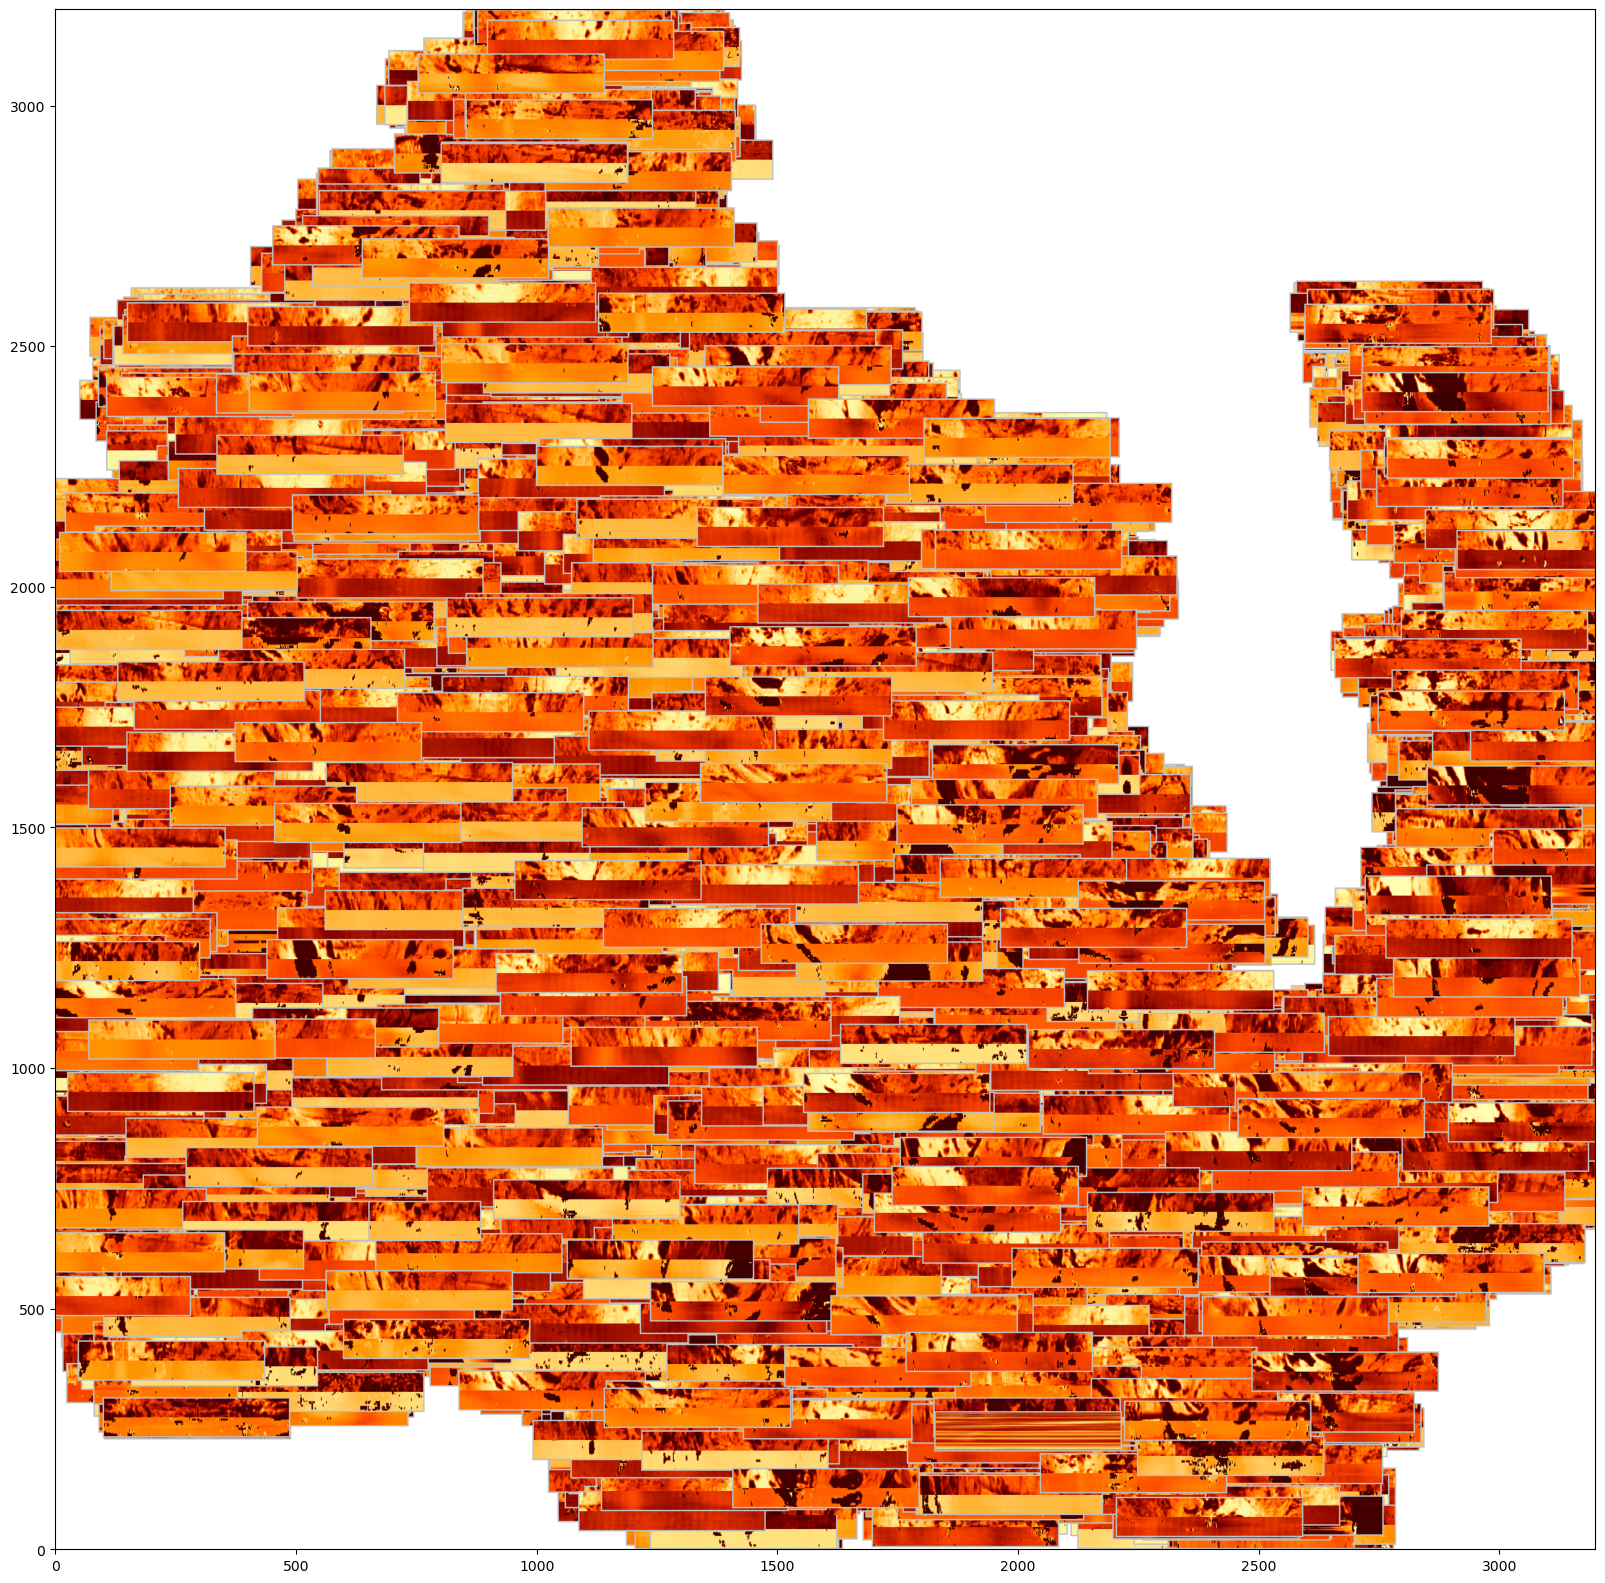

In [17]:
# plot_image = 255*np.ones((3200, 3200, 3), dtype=np.uint8)

# for aw,tt,x,y in tqdm(zip(images_AW, images_TT, tx, ty)):
#     center_x = x*plot_image.shape[1]
#     center_y = y*plot_image.shape[0]

#     image = np.concatenate((aw.transpose((1,2,0)), tt.transpose((1,2,0))), axis=0)
#     image = np.pad(image, pad_width=((3,3),(3,3),(0,0)), mode='constant', constant_values=127)
#     image = (255*(image+1)/2).astype(np.uint8)
    
#     left_coord = int(center_x-image.shape[1]/2)
#     right_coord = left_coord + image.shape[1]
    
#     bottom_coord = int(center_y-image.shape[0]/2)
#     top_coord = bottom_coord + image.shape[0]

#     debug_antes = f'antes: {left_coord=}, {right_coord=}, {bottom_coord=}, {top_coord=}, {image.shape=}'

#     if left_coord < 0:
#         image = image[:, abs(left_coord):]
#         # right_coord += left_coord
#         left_coord = 0
#     if right_coord > plot_image.shape[1]:
#         diff = right_coord - plot_image.shape[1]
#         image = image[:, :image.shape[1]-diff]
#         right_coord = plot_image.shape[1]

#     if bottom_coord < 0:
#         image = image[abs(bottom_coord):]
#         # top_coord += bottom_coord
#         bottom_coord = 0
#     if top_coord > plot_image.shape[0]:
#         diff = top_coord - plot_image.shape[0]
#         image = image[:image.shape[0]-diff]
#         top_coord = plot_image.shape[0]

#     debug_depois = f'depois: {left_coord=}, {right_coord=}, {bottom_coord=}, {top_coord=}, {image.shape=}'

#     # print(center_x, center_y)
#     # print(left_coord, right_coord, bottom_coord, top_coord)
#     # print(image.shape, image.dtype, image.max())

#     try:
#         plot_image[
#             bottom_coord:top_coord,
#             left_coord:right_coord,
#             :
#         ] = image[::-1]
#     except ValueError:
#         print(center_x, center_y)
#         print(debug_antes)
#         print(debug_depois)
#         raise Exception()

In [ ]:
# # Compute the coordinates of the image on the plot
# def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
#     image_height, image_width, _ = image.shape
 
#     # compute the image center coordinates on the plot
#     center_x = int(image_centers_area_size * x) + offset
 
#     # in matplotlib, the y axis is directed upward
#     # to have the same here, we need to mirror the y coordinate
#     center_y = int(image_centers_area_size * (1 - y)) + offset
 
#     # knowing the image center,
#     # compute the coordinates of the top left and bottom right corner
#     tl_x = center_x - int(image_width / 2)
#     tl_y = center_y - int(image_height / 2)
 
#     br_x = tl_x + image_width
#     br_y = tl_y + image_height
 
#     return tl_x, tl_y, br_x, br_y
 
# # we'll put the image centers in the central area of the plot
# # and use offsets to make sure the images fit the plot
 
# # init the plot as white canvas
# tsne_plot = 255 * np.ones((500, 2000, 3), np.uint8)
 
# # now we'll put a small copy of every image to its corresponding T-SNE coordinate
# for image_path, label, x, y in tqdm(
#         zip(images, labels, tx, ty),
#         desc='Building the T-SNE plot',
#         total=len(images)
# ):
#     # image = cv2.imread(image_path)
 
#     # scale the image to put it to the plot
#     # image = scale_image(image, max_image_size)
 
#     # draw a rectangle with a color corresponding to the image class
#     # image = draw_rectangle_by_class(image, label)
 
#     # compute the coordinates of the image on the scaled plot visualization
#     tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)
 
#     # put the image to its t-SNE coordinates using numpy sub-array indices
#     tsne_plot[tl_y:br_y, tl_x:br_x, :] = image